In [2]:
import torch
import torch.nn as nn

from torchvision import datasets, transforms
import torch.optim as optim

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

from tqdm.auto import tqdm


# Xarxes convolucionals multiclasse

Aquesta pràctica està enfocada en l'extensió dels conceptes apresos anteriorment sobre les xarxes neuronals convolucionals (CNN) aplicades a la classificació binària. En la sessió passada, vam treballar amb problemes de classificació on només hi havia dues categories possibles. Ara farem un pas més endavant i ens centrarem en els problemes de classificació multiclasse, on un conjunt de dades pot tenir més de dues classes o categories possibles.

L'objectiu d'aquesta pràctica és entendre com les CNN poden adaptar-se a problemes multiclasse, i com els canvis en l'arquitectura, la funció de pèrdua i el processament de sortida permeten gestionar aquesta complexitat addicional. A més, explorarem les estratègies més adequades per a l'entrenament de models en aquest context, i veurem com interpretar els resultats obtinguts en un escenari amb múltiples categories.

Aquesta pràctica proporcionarà una base sòlida per abordar problemes de classificació en aplicacions reals, com ara el reconeixement d'imatges amb més d'una etiqueta possible.

## Dades

El conjunt de dades [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) és una versió alternativa al MNIST, que consisteix en imatges de roba en lloc de dígits escrits a mà. És un conjunt de dades de classificació multiclasse molt utilitzat per a tasques d'aprenentatge automàtic i visió per computador, i s'ha convertit en un estàndard per provar models de xarxes neuronals.

El conjunt conté un total de 70.000 imatges en escala de grisos, cadascuna amb una mida de 28x28 píxels, distribuïdes en 10 categories diferents de peces de vestir, com per exemple samarretes, pantalons, sabates, i altres articles de moda. Hi ha 60.000 imatges per a entrenament i 10.000 per a proves.

Cada imatge està etiquetada amb un valor entre 0 i 9, que correspon a un tipus de roba.

![Exemples de Fashion MNIST](https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png)




In [4]:
DOWNLOAD = True
BATCH_SIZE = 64
EPOCHS = 5

transform = transforms.Compose([
    transforms.ToTensor(),
])


train= datasets.FashionMNIST("../data", train=True, download=DOWNLOAD, transform=transform)
test=datasets.FashionMNIST("../data", train=False, download=DOWNLOAD, transform=transform)

train_loader = torch.utils.data.DataLoader(train, BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test, BATCH_SIZE)

100%|██████████| 26421880/26421880 [00:01<00:00, 18735828.82it/s]


Extracting ../data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 685513.81it/s]


Extracting ../data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:00<00:00, 10094788.85it/s]


Extracting ../data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ../data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]

Extracting ../data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ../data\FashionMNIST\raw



In [5]:
img, target = next(iter(train_loader))
print(img.shape)

torch.Size([64, 1, 28, 28])


## Definició de la xarxa

En primer lloc, declaram una xarxa (CNN) partim de la que vàreu emprar ahir amb en Biel:

In [12]:
model_cnn = nn.Sequential(
    torch.nn.Conv2d(in_channels= 1, out_channels= 4, kernel_size=(3,3), stride=1, padding="same"),
    torch.nn.MaxPool2d(kernel_size=(2,2)),
    torch.nn.ReLU(),

    torch.nn.Conv2d(in_channels= 4, out_channels= 8, kernel_size=(3,3), stride=1, padding="same"),
    torch.nn.MaxPool2d(kernel_size=(2,2)),
    torch.nn.ReLU(),

    torch.nn.Flatten(1),

    torch.nn.Linear(392, 10),
    nn.ReLU(),
    torch.nn.Linear(10, 10),
    nn.ReLU(),
    torch.nn.Linear(10, 1),
)

**Per poder resoldre el problema d'avui s'ha de modificar**


## Entrenament CNN

Ara partint de l'entrenament d'ahir heu d'adaptar-lo a multiclasse. Per fer-ho hem de canviar tot un conjunt d'elements:

-   **Funció de pèrdua**. La funció de pèrdua que hem emprat fins ara està especialment dissenyada per problemes binaris hem trobar-ne una que serveixi per multiclasse. La funció que hem emprat [``BCEWithLogits``](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html) (binary cross entropy) a més té una peculiaritat: inclou una funció Sigmoide. A la plana de [pytorch](https://pytorch.org/docs/stable/nn.html#loss-functions) podreu veure totes les funcions de pèrdua que hi ha.
-   **Sortida de la xarxa**. La xarxa ha de retornar una codificació adequada per més de dues classes.

Les funcions sigmoide i softmax són dues funcions d'activació molt utilitzades en xarxes neuronals, especialment en tasques de classificació, però tenen aplicacions diferents
segons el tipus de problema.

### Funció Sigmoide

La funció sigmoide es defineix com:

$$\sigma(X) = \frac{1}{1+e^{-x}}$$

**Aquesta funció pren qualsevol valor real d'entrada i el transforma en un valor comprès entre 0 i 1.** Per aquest motiu, s'utilitza principalment en problemes de classificació binària, on l'objectiu és assignar una de dues possibles classes. La sortida de la funció sigmoide es pot interpretar com una probabilitat, fent que sigui especialment útil per a la sortida d'una xarxa neuronal en problemes on es busca predir una classe binària (0 o 1).

### Funció Softmax

La funció softmax s'utilitza en problemes de classificació multiclasse. Aquesta funció pren un vector d'entrades (generalment els valors generats a la sortida d'una capa final d'una xarxa neuronal) i el transforma en una distribució de probabilitats, assegurant que la suma de les probabilitats sigui igual a 1. La seva fórmula és:

$$SM(x_i) = \frac{e^x_i}{\sum^n_{j=1} e^{x_j}}$$

Aquí, $x_i$ és un dels valors de la sortida, i la funció calcula la probabilitat de cada classe relativa a les altres. Això fa que softmax sigui ideal per a problemes de classificació amb múltiples categories, ja que converteix els valors de la sortida en probabilitats que es poden utilitzar per predir quina és la classe més probable.

En resum:

- Sigmoide: útil per a classificació binària, genera una sortida entre 0 i 1.
- Softmax: s'utilitza en classificació multiclasse, distribueix probabilitats entre totes les classes.


In [13]:
loss_fn = # TODO
learning_rate = 1e-3  # Hiperparàmetre
optimizer = optim.Adam(model_cnn.parameters(), lr=learning_rate)

running_loss = []
running_acc = []

running_test_loss = []
running_test_acc_cnn = []

In [14]:
for t in tqdm(range(EPOCHS), desc="Èpoques"):
    batch_loss = 0
    batch_acc = 0
    
    i_batch = 1
    # Iteram els batches.
    for i_batch, (x, y) in tqdm(enumerate(train_loader), desc=f"Batches (Època {t + 1})"):
        model_cnn.train()  # Posam el model a mode entranament.

        optimizer.zero_grad()

        # 1. PREDICCIÓ

        y_pred = model_cnn(x)


        # 2. CALCUL DE LA PÈRDUA
        # Computa la pèrdua: l'error de predicció vs el valor correcte
        # Es guarda la pèrdua en un array per futures visualitzacions

        loss = loss_fn(y_pred, y)

        #3. GRADIENT
        model_cnn.zero_grad()
        loss.backward()

        # Actualitza els pesos utilitzant l'algorisme d'actualització
        #4. OPTIMITZACIO
        with torch.no_grad():
            optimizer.step()

        # 5. EVALUAM EL MODEL
        model_cnn.eval()  # Mode avaluació de la xarxa


    running_loss.append(batch_loss / (i_batch + 1))
    # running_acc.append(batch_acc / (i_batch + 1))

    batch_test_loss = 0
    batch_test_acc = 0

    for i_batch, (x, y) in enumerate(test_loader):

        y_pred = model_cnn(x)
        y_pred_binary = (y_pred > 0.5).double()

        batch_test_loss += (loss_fn(y_pred, y).detach())
        # acc = accuracy_score(y_pred_binary.detach(), y.detach())
        # batch_test_acc += acc

    running_test_loss.append(batch_test_loss / (i_batch + 1))
    # running_test_acc_cnn.append(batch_test_acc / (i_batch + 1))

Èpoques:   0%|          | 0/5 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

C:\Users\miquel\miniconda3\envs\ia2024\Lib\site-packages\torch\nn\modules\module.py:1553: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Batches (Època 2): 0it [00:00, ?it/s]

Batches (Època 3): 0it [00:00, ?it/s]

Batches (Època 4): 0it [00:00, ?it/s]

Batches (Època 5): 0it [00:00, ?it/s]

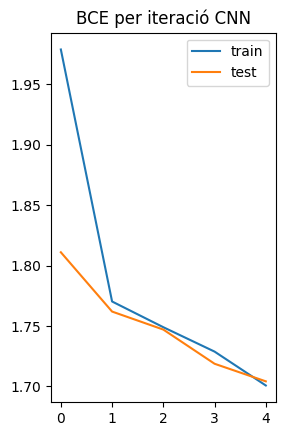

In [15]:
plt.subplot(1,2,1)
plt.title("Loss per iteració CNN")
plt.plot(running_loss, label="train")
plt.plot(running_test_loss, label="test")
plt.legend()

plt.subplot(1,2,2)
plt.title("Accuracy per iteració CNN")
plt.plot(running_acc, label="train")
plt.plot(running_test_acc_cnn, label="test")
plt.legend()
plt.show()

In [ ]:
running_test_acc_cnn[-1]

## Resultats

Aquí visualitzarem els resultats d'aprenentatge de la xarxa. 

### Feina a fer:

1. Adaptar la sortida del model per un problema multiclasse.
2. Emprar una funció de pèrdua adequada per un entorn multiclasse.
3. Obtenir l'accuracy en aquest entorn multiclasse.


*Subplots*

Per fer graelles d'imatges podeu empar la funció `subplots`. Més [informació](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html)

